In [170]:
import pandas as pd
import matplotlib.pyplot as plt


Analyse avec Number of Casualties en variable cible

In [171]:
data = pd.read_csv('Data_for_analysis.csv')
y = data['Number_of_Casualties']

X = data.drop(columns = ['Accident_Severity','Light_Conditions','Road_Surface_Conditions',
                         'Unnamed: 0','Number_of_Casualties','Number_of_Vehicles'])


In [172]:
X = X.astype(float)

Regression de Poisson simple

In [173]:
import statsmodels.api as sm

X = sm.add_constant(X)
ridge_poisson = sm.GLM(y, X, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge = ridge_poisson.params

poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

summary_table = poisson_model.summary2().tables[1]
summary_table["Coefficient (Ridge)"] = coef_ridge  # Ajouter les coefficients Ridge
summary_table = summary_table[["Coefficient (Ridge)", "Std.Err.", "z", "P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table.head(100)


,Coefficient (Ridge),Std.Err.,z,P>|z|
const,0.032414,0.850293,0.045806,0.963465
2021-02,-0.014686,0.164053,-0.621894,0.534012
2021-03,-0.013049,0.209323,-0.581276,0.561055
2021-04,0.011946,0.276007,-0.477650,0.632900
2021-05,-0.009940,0.340298,-0.723288,0.469503
2021-06,-0.009171,0.381478,-0.721355,0.470691
2021-07,0.017952,0.360338,-0.576195,0.564484
2021-08,-0.014198,0.300013,-0.728565,0.466268
2021-09,0.040144,0.240910,-0.114918,0.908510
2021-10,-0.018145,0.177760,-0.566897,0.570784


Très mauvais résultats avec des quasiment aucun des coefficients significatifs. Nous tentons  une autre approche en faisant une ACP, qui servirait a regrouper des variables colinéaires sur un même axe et simplifierait notre analyse

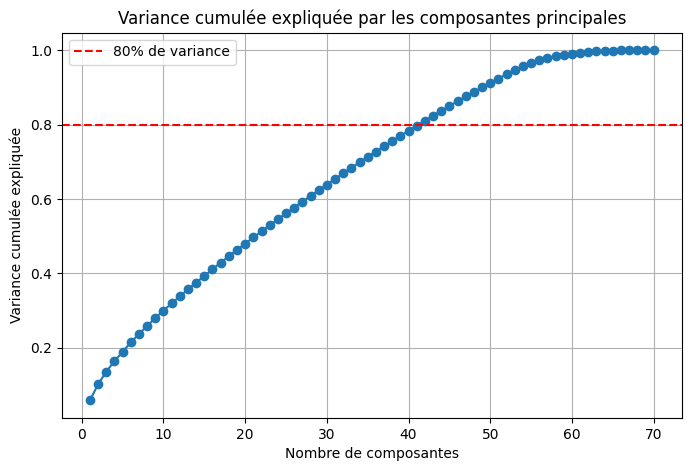

In [174]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réalisation de l'ACP sur toutes les composantes
pca_full = PCA()
pca_full.fit(X_scaled)
explained_variance = pca_full.explained_variance_ratio_

# Calcul de la variance cumulée
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée expliquée')
plt.title('Variance cumulée expliquée par les composantes principales')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% de variance')
plt.legend()
plt.grid(True)
plt.show()

In [175]:
X.shape

(1878, 70)

Nous avons voulu réduire les dimensions de notre modèle avec une ACP mais, pour atteindre un modèle qui explique au moins 80% de la variance, il nous aurait fallu choisir 50 composantes principales, ce qui est un chiffre bien trop élevé et enlève tout l'intérêt de l'ACP.

Stepwise Selection:

Forward step : tester l’ajout de chaque variable non incluse pour identifier celle qui diminue le plus l’AIC.

In [176]:
import statsmodels.api as sm

def stepwise_selection(X, y, initial_list=[], verbose=True):
    """
    Sélection de variables par régression pas à pas basée sur l’AIC.
    Utilise un modèle de Poisson (GLM) pour ajouter ou retirer des variables.
    
    Parameters:
      X: DataFrame des variables explicatives.
      y: Série de la variable cible.
      initial_list: Liste initiale (peut être vide).
      verbose: Affichage des étapes.
      
    Returns:
      La liste des variables sélectionnées.
    """
    included = list(initial_list)
    while True:
        changed = False
        
        # ----- Étape Forward : Ajouter la variable qui minimise l'AIC -----
        excluded = list(set(X.columns) - set(included))
        best_aic = float('inf')
        best_feature = None
        for new_column in excluded:
            model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included + [new_column]])),
                           family=sm.families.Poisson()).fit()
            current_aic = model.aic
            if current_aic < best_aic:
                best_aic = current_aic
                best_feature = new_column
        if best_feature is not None:
            if len(included) == 0:
                current_model_aic = float('inf')
            else:
                current_model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included])),
                                       family=sm.families.Poisson()).fit()
                current_model_aic = current_model.aic
            if best_aic < current_model_aic:
                included.append(best_feature)
                changed = True
                if verbose:
                    print('Ajouter {} avec AIC = {:.2f}'.format(best_feature, best_aic))
        
        # ----- Étape Backward : Supprimer la variable qui améliore l'AIC -----
        if len(included) > 0:
            model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included])),
                           family=sm.families.Poisson()).fit()
            current_aic = model.aic
            aic_with_drop = {}
            for feature in included:
                features_subset = list(included)
                features_subset.remove(feature)
                if len(features_subset) == 0:
                    aic_with_drop[feature] = float('inf')
                else:
                    temp_model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[features_subset])),
                                        family=sm.families.Poisson()).fit()
                    aic_with_drop[feature] = temp_model.aic
            worst_feature = min(aic_with_drop, key=aic_with_drop.get)
            worst_aic = aic_with_drop[worst_feature]
            if worst_aic < current_aic:
                included.remove(worst_feature)
                changed = True
                if verbose:
                    print('Supprimer {} pour AIC = {:.2f}'.format(worst_feature, worst_aic))
        
        if not changed:
            break

    return included

# Exemple d'utilisation :
# Supposons que "data_encoded" est votre DataFrame final avec 'Accident_Severity' comme variable cible.


selected_features_aic = stepwise_selection(X, y)
print("Variables sélectionnées :", selected_features_aic)

X_aic = X[selected_features_aic]

Ajouter Speed_limit avec AIC = 4691.89
Ajouter Urban_or_Rural_Area avec AIC = 4691.89
Variables sélectionnées : ['Speed_limit', 'Urban_or_Rural_Area']


Autre méthode de sélection de variable: Elastic Net combine la pénalité L1 et L2, initialise les coefs à 0 si ne sont pas révélateurs

In [177]:
import statsmodels.api as sm
import pandas as pd

# Supposons que X et y soient vos variables explicatives et la variable cible
# On ajoute une constante aux variables explicatives
X_const = sm.add_constant(X)

# Choix d'une valeur de régularisation
alpha_value = 0.1  # à ajuster selon vos besoins

# Ajustement d'un modèle de Poisson avec régularisation Elastic Net
# Ici, L1_wt=0.5 signifie un mélange égal entre L1 et L2.
model_reg = sm.GLM(y, X_const, family=sm.families.Poisson()).fit_regularized(alpha=alpha_value, L1_wt=0.5)

# Affichage des coefficients
print("Coefficients du modèle régularisé :")
print(model_reg.params)

# Sélection des variables dont le coefficient n'est pas négligeable (seuil arbitraire, par exemple 1e-4)
selected_features_en = model_reg.params[model_reg.params.abs() > 1e-4].index.tolist()

# Supprimer la constante si présente
if 'const' in selected_features_en:
    selected_features_en.remove('const')

print("Variables sélectionnées :", selected_features_en)
X_en = X[selected_features_en]


Coefficients du modèle régularisé :
const                                                   0.000000
2021-02                                                 0.000000
2021-03                                                 0.000000
2021-04                                                 0.000000
2021-05                                                 0.000000
2021-06                                                 0.000000
2021-07                                                 0.000000
2021-08                                                 0.000000
2021-09                                                 0.000000
2021-10                                                 0.000000
2021-11                                                 0.000000
2021-12                                                 0.000000
2022-01                                                 0.000000
2022-02                                                 0.000000
2022-03                                               

c:\Users\zoero\OneDrive\Bureau\M2\S1\data lake\projet\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1464: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")


In [178]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import PoissonRegressor



# Création du modèle de régression Poisson
poisson_model = PoissonRegressor(alpha=0.1, max_iter=1000)

# On choisit le nombre de variables à conserver (par exemple 10)
n_features_to_select = 10
selector = RFE(estimator=poisson_model, n_features_to_select=n_features_to_select, step=1)
selector = selector.fit(X_scaled, y)

selected_features_rfe = X.columns[selector.support_]
print("Variables sélectionnées par RFE :", selected_features_rfe.tolist())
X_rfe = X[selected_features_rfe]


Variables sélectionnées par RFE : ['2021-09', '2022-11', 'Speed_limit', 'Urban_or_Rural_Area', 'Day_of_Week_Thursday', 'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday', 'Junction_Detail_Roundabout', 'Road_Type_One way street', 'Road_Type_Single carriageway']


Sélection via un modèle d'arbre:

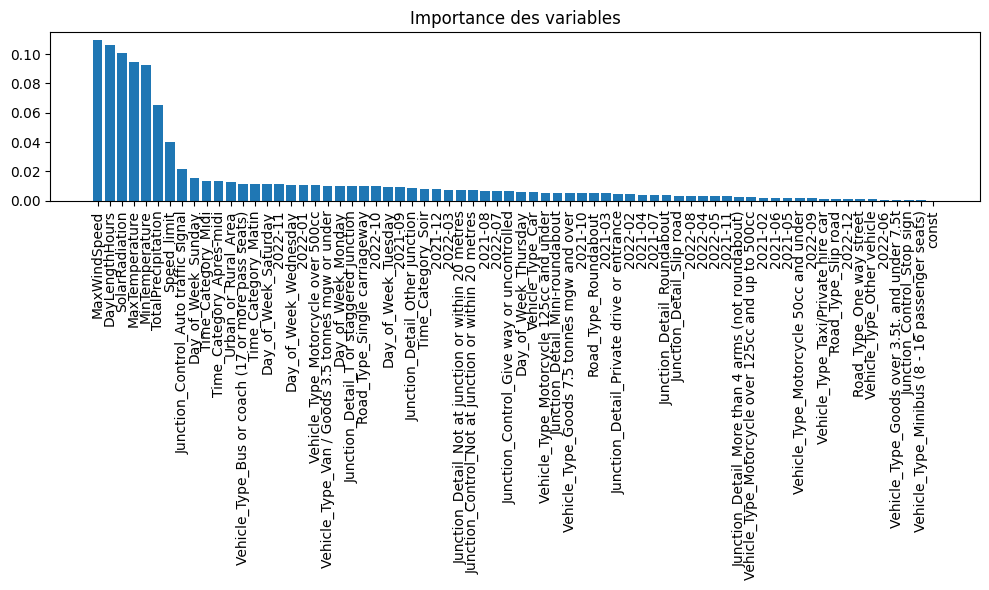

Variables retenues par seuil d'importance (>= 0.01) : ['2022-01', '2022-11', 'DayLengthHours', 'MaxTemperature', 'MaxWindSpeed', 'MinTemperature', 'SolarRadiation', 'Speed_limit', 'TotalPrecipitation', 'Urban_or_Rural_Area', 'Day_of_Week_Saturday', 'Day_of_Week_Sunday', 'Day_of_Week_Wednesday', 'Junction_Control_Auto traffic signal', 'Vehicle_Type_Bus or coach (17 or more pass seats)', 'Vehicle_Type_Motorcycle over 500cc', 'Time_Category_Matin', 'Time_Category_Midi', 'Time_Category_Après-midi']


In [179]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt



# Création d'un modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

# Récupération et tri des importances
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]
selected_features_rf = X.columns[indices]

# Affichage graphique des importances
plt.figure(figsize=(10, 6))
plt.title("Importance des variables")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), selected_features_rf, rotation=90)
plt.tight_layout()
plt.show()

# Vous pouvez ensuite retenir par exemple les variables dont l'importance est supérieure à un seuil.
threshold = 0.01
selected_features_rf_threshold = X.columns[importances >= threshold]
print("Variables retenues par seuil d'importance (>= 0.01) :", selected_features_rf_threshold.tolist())
X_tree = X[selected_features_rf_threshold]


Nous réappliquons la régression de poisson à chacun des nouveaux modèles et nous ne garderons que celui avec de meilleurs résultats

In [180]:
#1) avec AIC

ridge_poisson_aic = sm.GLM(y, X_aic, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge_aic = ridge_poisson_aic.params

poisson_model_aic = sm.GLM(y, X_aic, family=sm.families.Poisson()).fit()

summary_table_aic = poisson_model_aic.summary2().tables[1]
summary_table_aic["Coefficient (Ridge)"] = coef_ridge_aic  # Ajouter les coefficients Ridge
summary_table_aic = summary_table_aic[["Coef.",  "P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table_aic

,Coef.,P>|z|
Speed_limit,0.007144,4.446747e-38
Urban_or_Rural_Area,0.012675,6.863143e-01


1.010015e-11 se convertit en :
0.00000000001010015

Valeur p : 1.071450e-01 → 0.1071450

Valeur p : 1.830004e-01 → 0.1830004

In [181]:
#1) avec RFE

ridge_poisson_rfe = sm.GLM(y, X_rfe, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge_rfe = ridge_poisson_rfe.params

poisson_model_rfe = sm.GLM(y, X_rfe, family=sm.families.Poisson()).fit()

summary_table_rfe = poisson_model_rfe.summary2().tables[1]
summary_table_rfe["Coefficient (Ridge)"] = coef_ridge_rfe  # Ajouter les coefficients Ridge
summary_table_rfe = summary_table_rfe[["Coef.","P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table_rfe

,Coef.,P>|z|
2021-09,0.135096,1.463688e-01
2022-11,0.137902,1.475220e-01
Speed_limit,0.007283,2.199075e-21
Urban_or_Rural_Area,0.020067,6.009402e-01
Day_of_Week_Thursday,-0.062906,3.008991e-01
Day_of_Week_Tuesday,-0.054744,3.395986e-01
Day_of_Week_Wednesday,-0.059528,2.988864e-01
Junction_Detail_Roundabout,-0.092450,2.419113e-01
Road_Type_One way street,-0.111352,4.546118e-01
Road_Type_Single carriageway,0.019113,6.516819e-01


In [182]:

ridge_poisson_tree = sm.GLM(y, X_tree, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge_tree = ridge_poisson_tree.params

poisson_model_tree = sm.GLM(y, X_tree, family=sm.families.Poisson()).fit()

summary_table_tree = poisson_model_tree.summary2().tables[1]
summary_table_tree["Coefficient (Ridge)"] = coef_ridge_tree  # Ajouter les coefficients Ridge
summary_table_tree = summary_table_tree[["Coef.","P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table_tree.head(100)

,Coef.,P>|z|
2022-01,0.087761,0.449593
2022-11,0.137352,0.163510
DayLengthHours,0.011732,0.297639
MaxTemperature,-0.000688,0.939373
MaxWindSpeed,-0.000226,0.925684
MinTemperature,0.001161,0.898184
SolarRadiation,-0.005748,0.299530
Speed_limit,0.005000,0.001078
TotalPrecipitation,-0.002725,0.625528
Urban_or_Rural_Area,-0.054640,0.278806


Dernière méthode de sélection: supprimer les variables avec un VIF supérieur à 10:

In [183]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

X_vif = vif_data[vif_data["VIF"]<=10]
X_vif= X[X_vif['Variable']]

ridge_poisson_vif = sm.GLM(y, X_vif, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge_vif = ridge_poisson_vif.params

poisson_model_vif = sm.GLM(y, X_vif, family=sm.families.Poisson()).fit()

summary_table_vif = poisson_model_vif.summary2().tables[1]
summary_table_vif["Coefficient (Ridge)"] = coef_ridge_vif  # Ajouter les coefficients Ridge
summary_table_vif = summary_table_vif[["Coef.",  "P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table_vif

,Coef.,P>|z|
2021-02,0.008108,0.949184
2021-03,0.037552,0.742481
2021-04,0.091364,0.436941
2021-09,0.128847,0.215632
2021-10,-0.010551,0.923307
2021-11,-0.012863,0.904179
2021-12,0.113028,0.323180
2022-01,0.146189,0.261904
2022-02,0.140937,0.234234
2022-03,0.138053,0.233050


In [184]:

ridge_poisson_en = sm.GLM(y, X_en, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge_en = ridge_poisson_en.params

poisson_model_en = sm.GLM(y, X_en, family=sm.families.Poisson()).fit()

summary_table_en = poisson_model_en.summary2().tables[1]
summary_table_en["Coefficient (Ridge)"] = coef_ridge_en  # Ajouter les coefficients Ridge
summary_table_en = summary_table_en[["Coef.",  "P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table_en

,Coef.,P>|z|
DayLengthHours,0.010294,2.101965e-01
MaxWindSpeed,-0.000166,9.411206e-01
SolarRadiation,-0.005875,2.029166e-01
Speed_limit,0.006014,4.291350e-07


changement d'y, on se demande si le nombre de victimes est >=1 si oui 1 sinon 0

In [185]:
y_bis =np.where(y == 1, 0, 1)
len(y_bis)

1878

In [186]:
model = sm.Logit(y_bis, X)

# Ajustement du modèle avec pénalité Lasso (régularisation L1)
# alpha détermine la force de la pénalisation (à ajuster selon votre problème)
result = model.fit_regularized(method='l1', alpha=0.1)


# Affichage du résumé du modèle
print(result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5249884021954929
            Iterations: 485
            Function evaluations: 493
            Gradient evaluations: 485
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1878
Model:                          Logit   Df Residuals:                     1808
Method:                           MLE   Df Model:                           69
Date:                Wed, 05 Feb 2025   Pseudo R-squ.:                 0.05546
Time:                        21:29:06   Log-Likelihood:                -983.24
converged:                       True   LL-Null:                       -1041.0
Covariance Type:            nonrobust   LLR p-value:                 0.0003872
                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

c:\Users\zoero\OneDrive\Bureau\M2\S1\data lake\projet\.venv\Lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 9 out of 70 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
c:\Users\zoero\OneDrive\Bureau\M2\S1\data lake\projet\.venv\Lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Robustesse 2: variable cible = nombre de vehicules impliqués

Analyse avec Number of Vehicules en variable cible

In [187]:
y = data['Number_of_Vehicles']

X = data.drop(columns = ['Accident_Severity','Light_Conditions','Road_Surface_Conditions',
                         'Unnamed: 0','Number_of_Casualties','Number_of_Vehicles'])


In [188]:
X = X.astype(float)

Regression de Poisson simple

In [189]:
import statsmodels.api as sm

X = sm.add_constant(X)
ridge_poisson = sm.GLM(y, X, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge = ridge_poisson.params

poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

summary_table = poisson_model.summary2().tables[1]
summary_table["Coefficient (Ridge)"] = coef_ridge  # Ajouter les coefficients Ridge
summary_table = summary_table[["Coef.","P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table.head(100)


,Coef.,P>|z|
const,0.925746,0.162620
2021-02,0.106951,0.441937
2021-03,0.133169,0.455633
2021-04,0.068572,0.772957
2021-05,0.115041,0.692775
2021-06,0.178045,0.584687
2021-07,0.178866,0.561793
2021-08,0.174368,0.496201
2021-09,0.142398,0.493725
2021-10,0.156919,0.296684


Très mauvais résultats avec des quasiment aucun des coefficients significatifs. Nous tentons  une autre approche en faisant une ACP, qui servirait a regrouper des variables colinéaires sur un même axe et simplifierait notre analyse

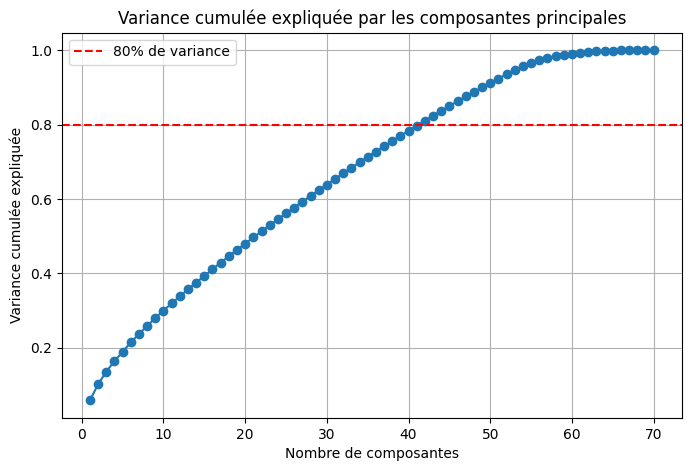

In [190]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réalisation de l'ACP sur toutes les composantes
pca_full = PCA()
pca_full.fit(X_scaled)
explained_variance = pca_full.explained_variance_ratio_

# Calcul de la variance cumulée
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée expliquée')
plt.title('Variance cumulée expliquée par les composantes principales')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% de variance')
plt.legend()
plt.grid(True)
plt.show()

In [191]:
X.shape

(1878, 70)

Nous avons voulu réduire les dimensions de notre modèle avec une ACP mais, pour atteindre un modèle qui explique au moins 80% de la variance, il nous aurait fallu choisir 50 composantes principales, ce qui est un chiffre bien trop élevé et enlève tout l'intérêt de l'ACP.

Stepwise Selection:

Forward step : tester l’ajout de chaque variable non incluse pour identifier celle qui diminue le plus l’AIC.

In [192]:
import statsmodels.api as sm

def stepwise_selection(X, y, initial_list=[], verbose=True):
    """
    Sélection de variables par régression pas à pas basée sur l’AIC.
    Utilise un modèle de Poisson (GLM) pour ajouter ou retirer des variables.
    
    Parameters:
      X: DataFrame des variables explicatives.
      y: Série de la variable cible.
      initial_list: Liste initiale (peut être vide).
      verbose: Affichage des étapes.
      
    Returns:
      La liste des variables sélectionnées.
    """
    included = list(initial_list)
    while True:
        changed = False
        
        # ----- Étape Forward : Ajouter la variable qui minimise l'AIC -----
        excluded = list(set(X.columns) - set(included))
        best_aic = float('inf')
        best_feature = None
        for new_column in excluded:
            model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included + [new_column]])),
                           family=sm.families.Poisson()).fit()
            current_aic = model.aic
            if current_aic < best_aic:
                best_aic = current_aic
                best_feature = new_column
        if best_feature is not None:
            if len(included) == 0:
                current_model_aic = float('inf')
            else:
                current_model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included])),
                                       family=sm.families.Poisson()).fit()
                current_model_aic = current_model.aic
            if best_aic < current_model_aic:
                included.append(best_feature)
                changed = True
                if verbose:
                    print('Ajouter {} avec AIC = {:.2f}'.format(best_feature, best_aic))
        
        # ----- Étape Backward : Supprimer la variable qui améliore l'AIC -----
        if len(included) > 0:
            model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included])),
                           family=sm.families.Poisson()).fit()
            current_aic = model.aic
            aic_with_drop = {}
            for feature in included:
                features_subset = list(included)
                features_subset.remove(feature)
                if len(features_subset) == 0:
                    aic_with_drop[feature] = float('inf')
                else:
                    temp_model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[features_subset])),
                                        family=sm.families.Poisson()).fit()
                    aic_with_drop[feature] = temp_model.aic
            worst_feature = min(aic_with_drop, key=aic_with_drop.get)
            worst_aic = aic_with_drop[worst_feature]
            if worst_aic < current_aic:
                included.remove(worst_feature)
                changed = True
                if verbose:
                    print('Supprimer {} pour AIC = {:.2f}'.format(worst_feature, worst_aic))
        
        if not changed:
            break

    return included

# Exemple d'utilisation :
# Supposons que "data_encoded" est votre DataFrame final avec 'Accident_Severity' comme variable cible.


selected_features_aic = stepwise_selection(X, y)
print("Variables sélectionnées :", selected_features_aic)

X_aic = X[selected_features_aic]

Ajouter Speed_limit avec AIC = 5145.64
Ajouter Junction_Detail_Not at junction or within 20 metres avec AIC = 5139.52
Ajouter const avec AIC = 5139.52
Variables sélectionnées : ['Speed_limit', 'Junction_Detail_Not at junction or within 20 metres', 'const']


Autre méthode de sélection de variable: Elastic Net combine la pénalité L1 et L2, initialise les coefs à 0 si ne sont pas révélateurs

In [193]:
import statsmodels.api as sm
import pandas as pd

# Supposons que X et y soient vos variables explicatives et la variable cible
# On ajoute une constante aux variables explicatives
X_const = sm.add_constant(X)

# Choix d'une valeur de régularisation
alpha_value = 0.1  # à ajuster selon vos besoins

# Ajustement d'un modèle de Poisson avec régularisation Elastic Net
# Ici, L1_wt=0.5 signifie un mélange égal entre L1 et L2.
model_reg = sm.GLM(y, X_const, family=sm.families.Poisson()).fit_regularized(alpha=alpha_value, L1_wt=0.5)

# Affichage des coefficients
print("Coefficients du modèle régularisé :")
print(model_reg.params)

# Sélection des variables dont le coefficient n'est pas négligeable (seuil arbitraire, par exemple 1e-4)
selected_features_en = model_reg.params[model_reg.params.abs() > 1e-4].index.tolist()

# Supprimer la constante si présente
if 'const' in selected_features_en:
    selected_features_en.remove('const')

print("Variables sélectionnées :", selected_features_en)
X_en = X[selected_features_en]


Coefficients du modèle régularisé :
const                                                   0.000000
2021-02                                                 0.000000
2021-03                                                 0.000000
2021-04                                                 0.000000
2021-05                                                 0.000000
2021-06                                                 0.000000
2021-07                                                 0.000000
2021-08                                                 0.000000
2021-09                                                 0.000000
2021-10                                                 0.000000
2021-11                                                 0.000000
2021-12                                                 0.000000
2022-01                                                 0.000000
2022-02                                                 0.000000
2022-03                                               

c:\Users\zoero\OneDrive\Bureau\M2\S1\data lake\projet\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1464: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")


In [194]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import PoissonRegressor



# Création du modèle de régression Poisson
poisson_model = PoissonRegressor(alpha=0.1, max_iter=1000)

# On choisit le nombre de variables à conserver (par exemple 10)
n_features_to_select = 10
selector = RFE(estimator=poisson_model, n_features_to_select=n_features_to_select, step=1)
selector = selector.fit(X_scaled, y)

selected_features_rfe = X.columns[selector.support_]
print("Variables sélectionnées par RFE :", selected_features_rfe.tolist())
X_rfe = X[selected_features_rfe]


Variables sélectionnées par RFE : ['2022-10', '2022-11', 'Speed_limit', 'Junction_Detail_Not at junction or within 20 metres', 'Junction_Detail_Private drive or entrance', 'Road_Type_One way street', 'Road_Type_Single carriageway', 'Time_Category_Matin', 'Time_Category_Midi', 'Time_Category_Après-midi']


Sélection via un modèle d'arbre:

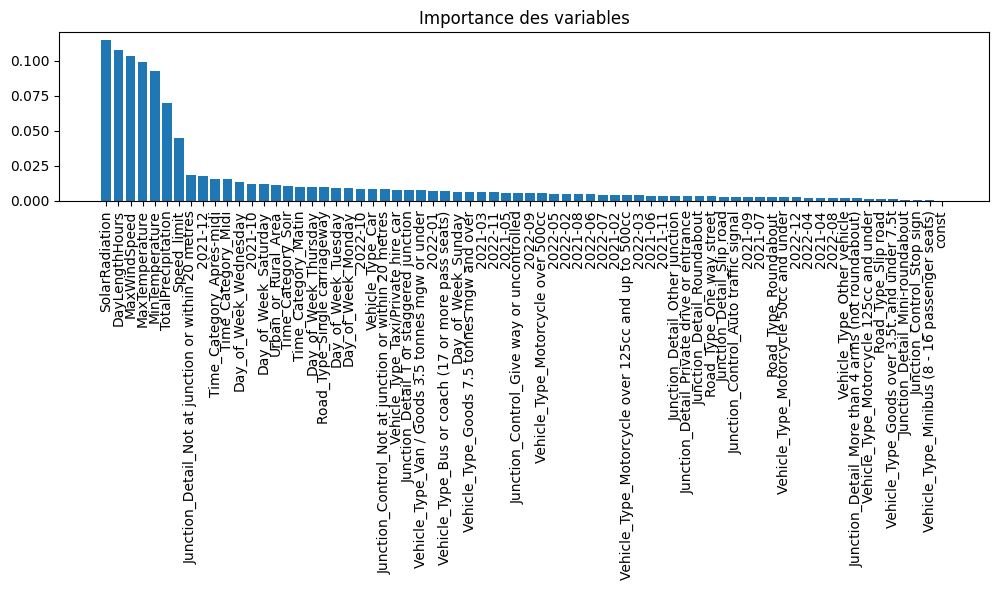

Variables retenues par seuil d'importance (>= 0.01) : ['2021-10', '2021-12', 'DayLengthHours', 'MaxTemperature', 'MaxWindSpeed', 'MinTemperature', 'SolarRadiation', 'Speed_limit', 'TotalPrecipitation', 'Urban_or_Rural_Area', 'Day_of_Week_Saturday', 'Day_of_Week_Wednesday', 'Junction_Detail_Not at junction or within 20 metres', 'Time_Category_Midi', 'Time_Category_Après-midi', 'Time_Category_Soir']


In [195]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt



# Création d'un modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

# Récupération et tri des importances
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]
selected_features_rf = X.columns[indices]

# Affichage graphique des importances
plt.figure(figsize=(10, 6))
plt.title("Importance des variables")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), selected_features_rf, rotation=90)
plt.tight_layout()
plt.show()

# Vous pouvez ensuite retenir par exemple les variables dont l'importance est supérieure à un seuil.
threshold = 0.01
selected_features_rf_threshold = X.columns[importances >= threshold]
print("Variables retenues par seuil d'importance (>= 0.01) :", selected_features_rf_threshold.tolist())
X_tree = X[selected_features_rf_threshold]


Nous réappliquons la régression de poisson à chacun des nouveaux modèles et nous ne garderons que celui avec de meilleurs résultats

In [196]:
#1) avec AIC

ridge_poisson_aic = sm.GLM(y, X_aic, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge_aic = ridge_poisson_aic.params

poisson_model_aic = sm.GLM(y, X_aic, family=sm.families.Poisson()).fit()

summary_table_aic = poisson_model_aic.summary2().tables[1]
summary_table_aic["Coefficient (Ridge)"] = coef_ridge_aic  # Ajouter les coefficients Ridge
summary_table_aic = summary_table_aic[["Coef.","P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table_aic

,Coef.,P>|z|
Speed_limit,0.004670,1.119269e-04
Junction_Detail_Not at junction or within 20 metres,-0.105246,4.517446e-03
const,0.469086,8.461475e-22


1.010015e-11 se convertit en :
0.00000000001010015

Valeur p : 1.071450e-01 → 0.1071450

Valeur p : 1.830004e-01 → 0.1830004

In [197]:
#1) avec RFE

ridge_poisson_rfe = sm.GLM(y, X_rfe, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge_rfe = ridge_poisson_rfe.params

poisson_model_rfe = sm.GLM(y, X_rfe, family=sm.families.Poisson()).fit()

summary_table_rfe = poisson_model_rfe.summary2().tables[1]
summary_table_rfe["Coefficient (Ridge)"] = coef_ridge_rfe  # Ajouter les coefficients Ridge
summary_table_rfe = summary_table_rfe[["Coef.",  "P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table_rfe

,Coef.,P>|z|
2022-10,0.107973,1.726708e-01
2022-11,0.114744,1.673234e-01
Speed_limit,0.008807,1.092947e-22
Junction_Detail_Not at junction or within 20 metres,-0.098912,1.003370e-02
Junction_Detail_Private drive or entrance,0.080728,3.101829e-01
Road_Type_One way street,0.031531,7.960422e-01
Road_Type_Single carriageway,0.078830,2.152189e-02
Time_Category_Matin,0.230782,7.969075e-06
Time_Category_Midi,0.254326,1.298383e-07
Time_Category_Après-midi,0.254027,1.661455e-07


In [198]:

ridge_poisson_tree = sm.GLM(y, X_tree, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge_tree = ridge_poisson_tree.params

poisson_model_tree = sm.GLM(y, X_tree, family=sm.families.Poisson()).fit()

summary_table_tree = poisson_model_tree.summary2().tables[1]
summary_table_tree["Coefficient (Ridge)"] = coef_ridge_tree  # Ajouter les coefficients Ridge
summary_table_tree = summary_table_tree[["Coef.", "P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table_tree

,Coef.,P>|z|
2021-10,0.061814,4.556302e-01
2021-12,0.136885,1.068009e-01
DayLengthHours,0.024150,1.156312e-02
MaxTemperature,0.002042,7.902153e-01
MaxWindSpeed,0.001825,3.749866e-01
MinTemperature,-0.003624,6.367045e-01
SolarRadiation,-0.006038,1.989997e-01
Speed_limit,0.007013,3.379238e-07
TotalPrecipitation,0.000421,9.277615e-01
Urban_or_Rural_Area,0.063636,1.419248e-01


Dernière méthode de sélection: supprimer les variables avec un VIF supérieur à 10:

In [199]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

X_vif = vif_data[vif_data["VIF"]<=10]
X_vif= X[X_vif['Variable']]

ridge_poisson_vif = sm.GLM(y, X_vif, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge_vif = ridge_poisson_vif.params

poisson_model_vif = sm.GLM(y, X_vif, family=sm.families.Poisson()).fit()

summary_table_vif = poisson_model_vif.summary2().tables[1]
summary_table_vif["Coefficient (Ridge)"] = coef_ridge_vif  # Ajouter les coefficients Ridge
summary_table_vif = summary_table_vif[["Coef.", "P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table_vif

,Coef.,P>|z|
2021-02,0.099736,0.347676
2021-03,0.079475,0.403451
2021-04,-0.010959,0.914687
2021-09,0.033201,0.722247
2021-10,0.078400,0.388682
2021-11,-0.006789,0.940938
2021-12,0.127278,0.192640
2022-01,0.092759,0.418113
2022-02,-0.007995,0.940378
2022-03,-0.023060,0.826012


In [200]:

ridge_poisson_en = sm.GLM(y, X_en, family=sm.families.Poisson()).fit_regularized(alpha=0.1, L1_wt=0.0)


coef_ridge_en = ridge_poisson_en.params

poisson_model_en = sm.GLM(y, X_en, family=sm.families.Poisson()).fit()

summary_table_en = poisson_model_en.summary2().tables[1]
summary_table_en["Coefficient (Ridge)"] = coef_ridge_en  # Ajouter les coefficients Ridge
summary_table_en = summary_table_en[["Coef.",  "P>|z|"]]  # Filtrer les colonnes utiles

pd.set_option("display.max_rows", None)
summary_table_en

,Coef.,P>|z|
DayLengthHours,0.019673,4.559123e-08
MaxWindSpeed,0.005653,7.071922e-04
Speed_limit,0.005814,6.707269e-09


changement d'y, on se demande si le nombre de victimes est >=1 si oui 1 sinon 0

In [201]:
y_bis =np.where(y > 2, 1, 0)
len(y_bis)

1878

In [202]:
model = sm.Logit(y_bis, X)

# Ajustement du modèle avec pénalité Lasso (régularisation L1)
# alpha détermine la force de la pénalisation (à ajuster selon votre problème)
result = model.fit_regularized(method='l1', alpha=0.1)


# Affichage du résumé du modèle
print(result.summary())

c:\Users\zoero\OneDrive\Bureau\M2\S1\data lake\projet\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\zoero\OneDrive\Bureau\M2\S1\data lake\projet\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3217284010158963
            Iterations: 548
            Function evaluations: 556
            Gradient evaluations: 548
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1878
Model:                          Logit   Df Residuals:                     1808
Method:                           MLE   Df Model:                           69
Date:                Wed, 05 Feb 2025   Pseudo R-squ.:                 0.09212
Time:                        21:29:20   Log-Likelihood:                -601.02
converged:                       True   LL-Null:                       -662.01
Covariance Type:            nonrobust   LLR p-value:                 8.840e-05
                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

c:\Users\zoero\OneDrive\Bureau\M2\S1\data lake\projet\.venv\Lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 6 out of 70 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
c:\Users\zoero\OneDrive\Bureau\M2\S1\data lake\projet\.venv\Lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
